In [171]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from shapely.geometry import Point

In [10]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)

In [11]:
geodata['centroid'] = geodata.centroid

<AxesSubplot:>

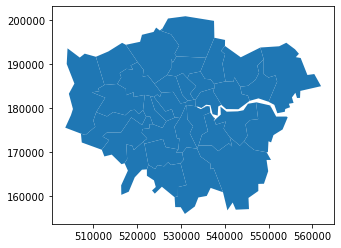

In [12]:
geodata.plot()

In [120]:
neighbours = geodata.sjoin(geodata, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

In [121]:
def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

neighbours['target_angle'] = neighbours.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'target_angle']]

In [122]:
neighbours

,LAD20CD_left,LAD20CD_right,target_angle
281,E09000001,E09000022,-1.797682
286,E09000006,E09000022,2.514451
288,E09000008,E09000022,1.799088
304,E09000024,E09000022,0.763387
308,E09000028,E09000022,-2.456275
...,...,...,...
306,E09000026,E09000002,-0.806490
304,E09000024,E09000021,-2.769225
307,E09000027,E09000021,-1.256605
309,E09000029,E09000021,2.780267


In [123]:
crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['centroid_left'].distance(row['centroid_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

In [124]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,E09000001,E09000002,21.0,0.237293
2,E09000001,E09000003,18.0,2.207847
3,E09000001,E09000004,24.0,-0.334989
4,E09000001,E09000005,16.0,2.777032
5,E09000001,E09000006,27.0,-0.978932
...,...,...,...,...
1083,E09000033,E09000028,8.0,-0.612246
1084,E09000033,E09000029,25.0,-1.619409
1085,E09000033,E09000030,10.0,0.073124
1086,E09000033,E09000031,18.0,0.751657


In [97]:
# Create an initial grid

initial_scale_factor = 2

full_bounds = geodata.total_bounds
axis_ratio = (full_bounds[3]-full_bounds[1])/(full_bounds[2]-full_bounds[0])
initial_y_length = int(np.round(initial_scale_factor*np.sqrt(len(geodata)/axis_ratio), decimals=0))
initial_x_length = int(np.round(axis_ratio*initial_y_length))

initial_grid = np.meshgrid(range(initial_x_length), range(initial_x_length))
initial_grid_size = initial_y_length*initial_x_length

In [208]:
# Randomly allocate codes to grid locations
codes_list = geodata['LAD20CD'].values
initial_coords = np.unravel_index(random.sample(range(initial_grid_size), len(codes_list)), (initial_x_length, initial_y_length))

# initial_layout = np.zeros((initial_x_length, initial_y_length), dtype=object)

# for code,x,y in zip(codes_list,initial_coords[0],initial_coords[1]):
#     initial_layout[x,y] = code

In [209]:
initial_coords

(array([4, 5, 0, 6, 2, 5, 7, 3, 8, 5, 5, 4, 0, 7, 0, 1, 7, 9, 8, 3, 7, 0,
        2, 5, 4, 1, 9, 1, 1, 8, 9, 0, 0]),
 array([10,  2,  2,  2,  0,  4,  0,  4,  5, 12, 10,  5, 10,  2,  3,  6,  4,
        11, 10,  6,  1, 12,  3,  3,  4,  4,  3,  1, 12,  6,  2,  8,  4]))

In [250]:
neighbour_distance_factor = 1
neighbour_angle_factor = 1



def generate_geodataframe(codes, coords):
    
    grid_pdf = pd.DataFrame({
        'code': codes,
        'y': coords[0],
        'x': coords[1]
    })
    grid_gdf = gpd.GeoDataFrame(grid_pdf, geometry=gpd.points_from_xy(grid_pdf['x'], grid_pdf['y']))
    grid_gdf.crs = 'epsg:27700'
    
    return grid_gdf[['code', 'geometry']]


def angle_difference(angle1, angle2):
    d = angle2-angle1
    d = d+(2*np.pi) if d < -np.pi else d
    d = d-(2*np.pi) if d > np.pi else d
    return d


def get_metric(it_gdf):
    
    # Find the distances and angles to all the neighbours
    it_neighbours = it_gdf.merge(neighbours, left_on='code', right_on='LAD20CD_left')
    it_neighbours = it_neighbours.merge(it_gdf, left_on='LAD20CD_right', right_on='code', suffixes=('', '_r'))
    it_neighbours = it_neighbours[['code', 'geometry', 'code_r', 'geometry_r', 'target_angle']]

    it_neighbours['distance'] = it_neighbours.apply(lambda row: row['geometry'].distance(row['geometry_r']), axis=1)
    it_neighbours['angle'] = it_neighbours.apply(lambda row: angle_between(row['geometry'], row['geometry_r']), axis=1)
    it_neighbours['angle_diff'] = it_neighbours.apply(lambda row: angle_difference(row['angle'], row['target_angle']), axis=1)

    # Define the neighbour metric
    it_neighbours['neighbour_metric'] = it_neighbours.apply(lambda row: (neighbour_distance_factor*row['distance']**2)+(neighbour_angle_factor*row['angle_diff']**2), axis=1)
    neighbour_metric = it_neighbours.groupby('code')['neighbour_metric'].sum().reset_index()


    it_gdf = it_gdf.merge(neighbour_metric, on='code', how='left')
    it_gdf['metric'] = it_gdf['neighbour_metric']
    return it_gdf


def find_it_gdf(codes_list, coords):
    it_gdf = generate_geodataframe(codes_list, coords)
    return get_metric(it_gdf)

def do_swaps(gdf):
    
    max_metric = gdf[gdf['metric']==gdf['metric'].max()]
    
    original_loc = max_metric['geometry'].values[0]
    original_x, original_y = original_loc.xy
    
    directions = []
    metrics = []
    new_dfs = []
    
    for x_shift, EW in zip([-1,0,1], ['W', 'C', 'E']):
        for y_shift, NS in zip([-1,0,1], ['S', 'C', 'N']):
            directions.append(NS+EW)
            new_loc = Point((original_x[0]+x_shift, original_y[0]+y_shift))
            
            new_df = gdf
            new_df.loc[(new_df['geometry']==new_loc), 'geometry'] = original_loc
            new_df.loc[(new_df['metric']==gdf['metric'].max()), 'geometry'] = new_loc
            
            new_df = get_metric(new_df[['code', 'geometry']])
            new_dfs.append(new_df)
            metrics.append(new_df['metric'].sum())

    dir_to_use = directions[np.argmin(metrics)]
    if dir_to_use == "CC":
        print('NO CHANGE')
    
    return new_dfs[np.argmin(metrics)]

In [251]:
initial_gdf = find_it_gdf(codes_list, initial_coords)
new_df = do_swaps(initial_gdf)
# s = do_swaps(initial_gdf)
# [s[c].xy for c in s.keys()]
# do_swaps(initial_gdf)['CC'].plot(column='metric')
# do_swaps(initial_gdf)['SW'].plot(column='metric')

<AxesSubplot:>

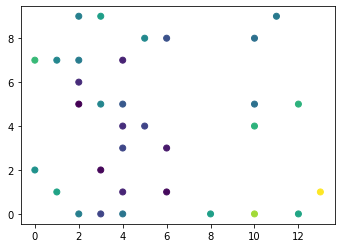

In [253]:
initial_gdf.plot(column='metric')

<AxesSubplot:>

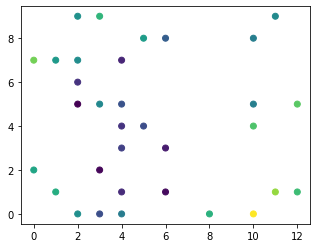

In [255]:
new_df.plot(column='metric')

In [55]:
9.8*7.57

74.186